# Segmentación por Regiones<a class="tocSkip">
## TRATAMIENTO DE SEÑALES <a class="tocSkip">
### Ingenieria Electrónica <a class="tocSkip">
### Universidad Popular del Cesar <a class="tocSkip">
### Prof.: Jose Ramón Iglesias Gamarra - [https://github.com/joseramoniglesias/](https://github.com/joseramoniglesias/) <a class="tocSkip">
  **joseiglesias@unicesar.edu.co**

# Region Segmentation

Region Detection using OTSU, MSER, etc.


# Libraries

In [1]:
import matplotlib.pylab as plt
import cv2
import numpy as np
from skimage.morphology import binary_dilation
from skimage.segmentation import clear_border,find_boundaries
from skimage.morphology import disk
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import find_contours
from skimage.morphology import remove_small_holes, remove_small_objects
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import find_contours
from skimage.morphology import binary_closing
from skimage.measure import label, regionprops


In [2]:
from skimage.color import label2rgb
from skimage.measure import label

# (c) Christian Pieringer and Domingo Mery

def binview(img, mask, color='r', dilate_pixels=1):
    """
    Displays a gray or color image 'img' overlaid by color pixels determined a by binary image 'mask'. It is useful to
    display the edges of an image.

    Args:
        img: gray scale image (X-ray)
        mask: binary image that works as mask
        color: string to define pixel color.
                'r': red (default)
                'g': green
                'b': blue
                'y': yellow
                'c': cyan
                'm': magenta
                'k': black
                'w': white

        dilate_pixels (int): Number of pixels used for dilate the mask.

    Returns:
        img_color (ndarray): output image with a mask overlaid.
    """

    # Defines colors
    # colors = {
    #     'r': np.array([255, 0, 0]),
    #     'g': np.array([0, 255, 0]),
    #     'b': np.array([0, 0, 255]),
    #     'y': np.array([255, 255, 0]),
    #     'c': np.array([0, 255, 255]),
    #     'm': np.array([255, 0, 255]),
    #     'k': np.array([0, 0, 0]),
    #     'w': np.array([255, 255, 255])
    # }
    #
    colors = {
        'r': np.array([1, 0, 0]),
        'g': np.array([0, 1, 0]),
        'b': np.array([0, 0, 1]),
        'y': np.array([1, 1, 0]),
        'c': np.array([0, 1, 1]),
        'm': np.array([1, 0, 1]),
        'k': np.array([0, 0, 0]),
        'w': np.array([1, 1, 1])
    }
    # Create a RGB image from grayscale image.
    img_color = np.dstack((img, img, img))

    # Ensure do not modify the original color image and the mask
    img_color = img_color.copy()

    mask_ = mask.copy()
    # mask_ = dilate(mask_, np.ones((g, g), np.uint8))
    mask_ = binary_dilation(mask_, np.ones((dilate_pixels, dilate_pixels)))

    # Now black-out the area of the mask
    # img_fg = bitwise_and(img, img, mask=mask_)

    # Defines the pixel color used for the mask in the figure.
    cc = colors[color]
    #
    # for i in range(3):
    #     img_color[:, :, i] = cc[i] * img_fg

    # remove artifacts connected to image border
    cleared = clear_border(mask_)
    if np.all(cleared):
        mask_ = cleared

    # label image regions
    label_image = label(mask_)
    img_color = label2rgb(label_image, image=img_color, colors=[cc], bg_label=0)

    return img_color  # add(img_color, img_color)


# Otsu

## Basic


In [3]:
def imhist(X):
  (N,M) = X.shape
  n = 256
  h = np.zeros((256,))
  for i in range(N):
    for j in range(M):
      x = X[i,j]
      h[x] = h[x]+1
  return h


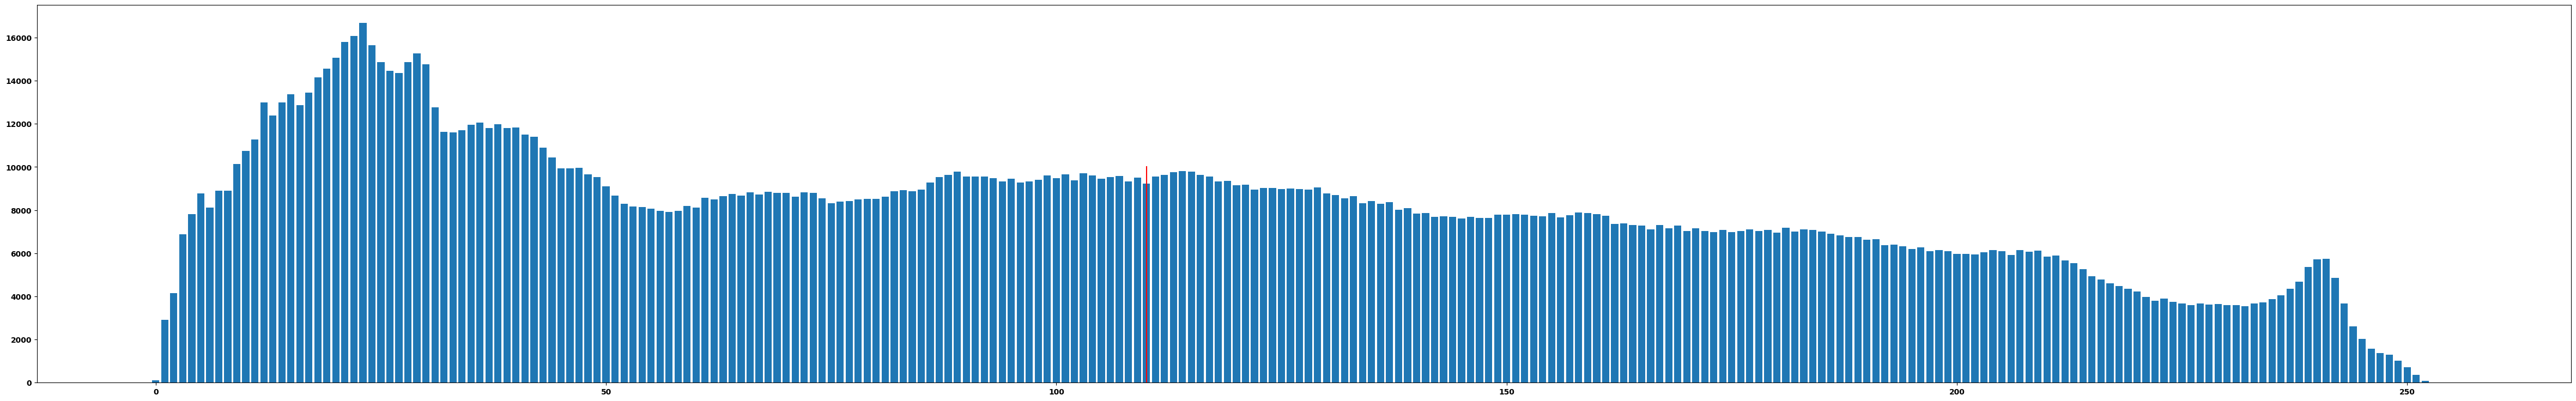

otsu-threshold =  110


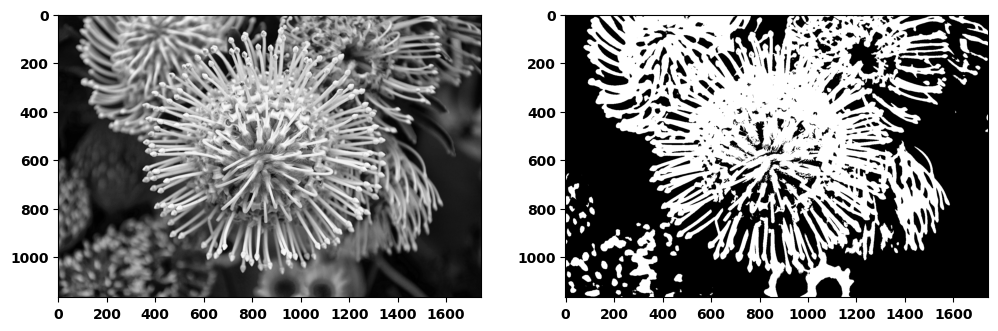

In [12]:
img = cv2.imread('tazmania.png',0)
h   = imhist(img)
plt.figure(figsize=(60,9))
plt.bar(range(256),h)
th  = threshold_otsu(img)
plt.plot([th,th],[0,10000],c='red')
plt.show()
print('otsu-threshold = ',th)
seg = img > th
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(seg,cmap='gray')
plt.show()


## Bimodal Segmentation

In [13]:
def seg_bimodal(img, p=-0.1):
    """

    :param img: numpy array for a gray-scale input image.
    :param p: float to denote the offset of threshold with p between -1 and 1. A
                positive value is used to dilate the segmentation, the negative
                to erode.
    :return: a tuple with the binary image and the contour of the mask.

    """
    img_d = img.astype('double')
    imax = np.max(img_d.flatten())
    imin = np.min(img_d.flatten())
    img_j = (img_d - imin) / (imax - imin)  # Image normalization [0, 1]

    ni = int(np.fix(img_j.shape[0] / 4))
    nj = int(np.fix(img_j.shape[1] / 4))

    # An heuristic method to ensure that the segmented object will
    # be labeled as 1.
    if np.mean(img_j[0:ni, 0:nj].flatten()) > 0.3:
        img_j = 1 - img_j

    # Transform a double image to unit8
    img_jj = (255 * img_j).astype('uint8')

    # Apply Gaussian filtering to remove noise and compute Otsu thresholding.
    # This step improve the thresholding
    img_jj = gaussian(img_jj, 2.0)
    level = threshold_otsu(img_jj)
    mask = img_jj > (level + p)

    a = remove_small_objects(mask, np.fix(len(mask.flatten()) / 100))
    c = binary_closing(a.astype('double'), disk(7))

    # Why 8?
    r = remove_small_holes(c, 8)
    contours = find_contours(r, 0.1)

    return r, contours

In [14]:
img = cv2.imread('tazmania.png',0)

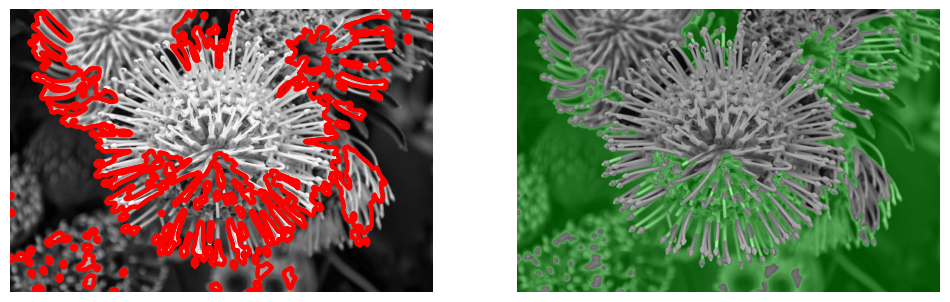

In [15]:
mask, contours = seg_bimodal(img)
seg = binview(img, mask, 'g')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img, cmap='gray')
for n, contour in enumerate(contours):
        ax[0].plot(contour[:, 1], contour[:, 0], color='r', linewidth=3)
ax[0].axis('off')
ax[1].imshow(seg)
ax[1].axis('off')
plt.show()


# Adaptive Thresholding

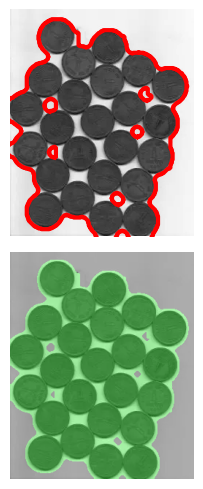

In [16]:
img = cv2.imread('monedas.png',0)

mask = np.zeros(img.shape, np.uint8)  # Create a uint8 mask image
max_width = img.shape[1]

d1 = int(np.round(max_width/4))
d2 = int(np.round(d1 * 1.5))

i1 = 0

while i1 < max_width:
    i2 = min(i1 + d2, max_width)  # second column of partition
    img_i = img[:, i1:i2]  # partition i
    bw_i, _ = seg_bimodal(img_i)  # segmentation of partition i
    roi = mask[:, i1:i2]
    overlap = np.bitwise_or(roi, bw_i)  # addition into whole segmentation
    mask[:, i1:i2] = overlap
    i1 = i1 + d1  # update of first column


seg = binview(img, mask, color='g', dilate_pixels=5)

contours = find_contours(np.float32(mask), 0.5)

fig, ax = plt.subplots(2, 1, figsize=(14, 5))
ax[0].imshow(img, cmap='gray');
for n, contour in enumerate(contours):
        ax[0].plot(contour[:, 1], contour[:, 0], color='r', linewidth=3)
ax[0].axis('off')
ax[1].imshow(seg)
ax[1].axis('off')
fig.tight_layout()
plt.show()


# MSER

In [17]:
def seg_mser(_img, area=(60, 20000), min_div=0.2, max_var=0.25, delta=5, area_threshold=200):
    """
    Image segmentation using MSER algorithm.

    Args:
        _img (ndarray): input image (uint8)
        area (int tuple): Range of areas to prune (min_area, max_area)
        min_div (float): Trace back to cut off MSER with diversity less than min_diversity
        max_var (float): Prune the area that have simliar size to its children
        delta (int): Controls how the stability is calculated comparing (sizei - sizei-delta) / sizei-delta. [1]
        area_threshold (float): the area threshold to cause re-initialize in color images [1]

    Returns:
       mask (ndarray): Binary image with detected objects
       label_regions (ndarray): Image with labels of the detected objects
       bboxes (ndarray): Bounding boxes for each detection in label_regions (x0, y0, width, height), where (x0, y0) is
                         the uppper-left corner.


    [1] Please check the OpenCV documentation for more details.
    """

    mser_opts = {
        'min_area': area[0],
        'max_area': area[1],
        'max_variation': max_var,
        'min_diversity': min_div,
        'delta': delta,
        'area_threshold': area_threshold
    }

    mser = cv2.MSER_create(**mser_opts)
    regions, bbox = mser.detectRegions(_img)

    mask = np.zeros(_img.shape)

    for dd, region in enumerate(regions):
        mask[region[:,1], region[:,0]] = 1

    label_regions, m = label(mask, connectivity=1, return_num=True)
    props = regionprops(label_regions)
    bboxes = np.array([[p.bbox[1], p.bbox[0], p.bbox[3] - p.bbox[1], p.bbox[2] - p.bbox[0]] for p in props])

    return mask, label_regions, bboxes


In [18]:
def plot_bboxes(bounding_boxes, color='lawngreen', linewidth=1.5, ax=None):
    """
    Plot a set of bounding boxes.

    Args:
        bounding_boxes (ndarray): array of bounding boxes (x0, y0, width, height), where x0, y0 is the upper-left corner.
        color (str): Edge color of the bounding box. Use matplotlib color names.
        linewidth (float): Bounding box linewidth.
        ax (object): Figure axes. If None, create a new figure and axes.

    Returns:
        ax (object): Figure axes.
    """
    if not ax:
        fig, ax = plt.subplots(1, 1)

    for b, bbox in enumerate(bounding_boxes):
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor=color, linewidth=linewidth)
        ax.add_patch(rect)

    return ax



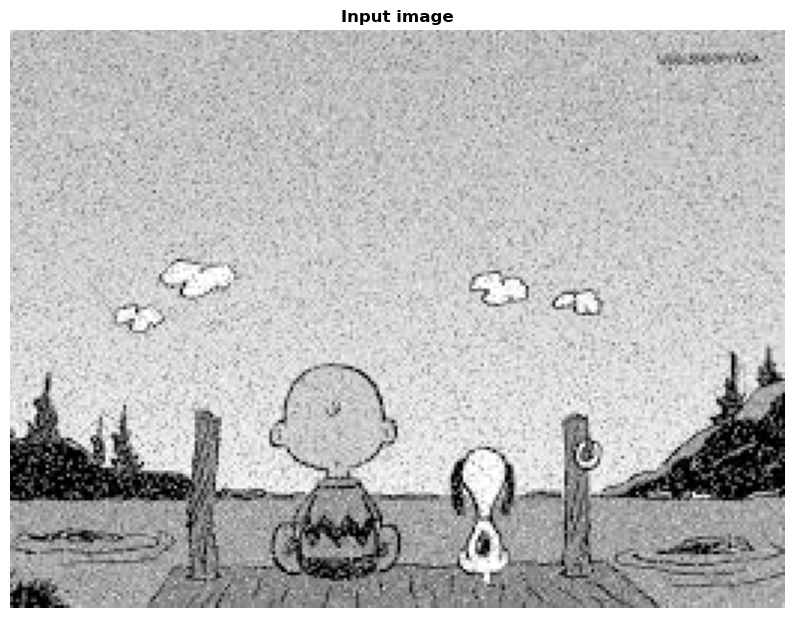

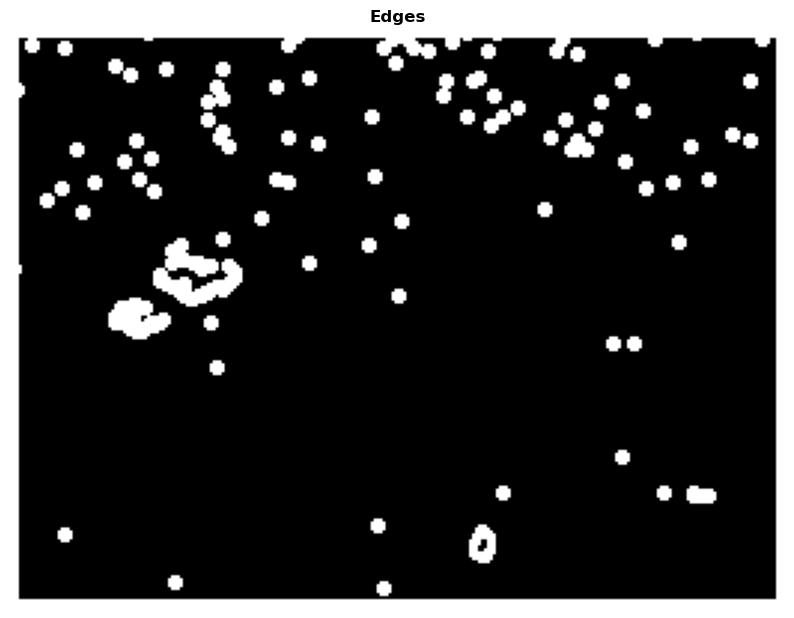

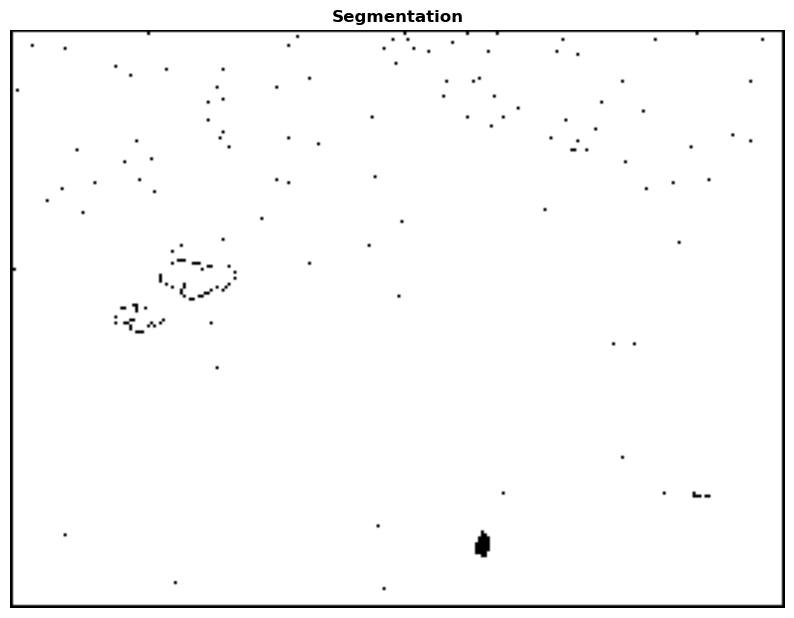

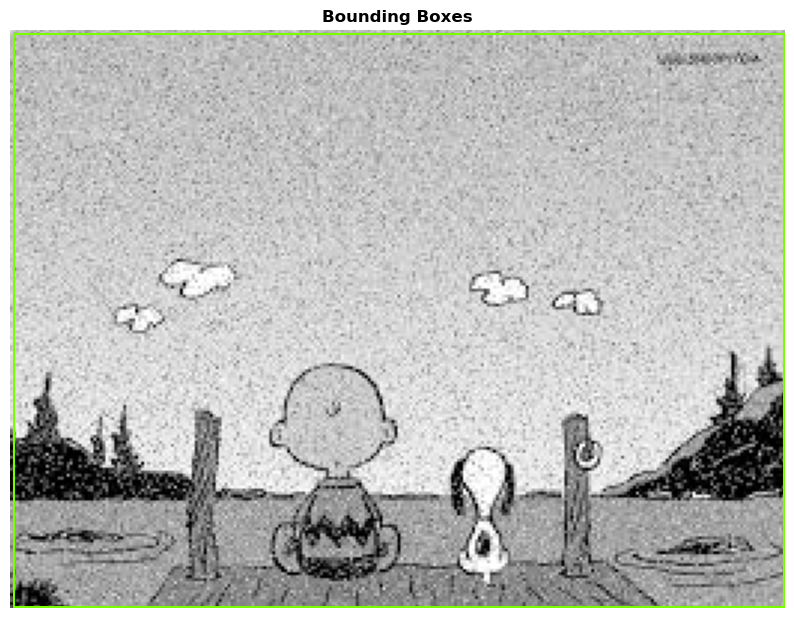

In [19]:
img = cv2.imread('charlie.jpg',0)

fig1, ax1 = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(img, cmap='gray')
ax1.set_title('Input image')
ax1.axis('off')
plt.show()

mser_options = {
    'area': (60, 40000),  # Area of the ellipse (Max, Min)
    'min_div': 0.9,  # Minimal diversity
    'max_var': 0.2,  # Maximal variation
    'delta': 3,  # Delta
}

J, L, bboxes = seg_mser(img, **mser_options)

E = binary_dilation(find_boundaries(J, connectivity=1, mode='inner'), np.ones((3, 3)))

fig2, ax2 = plt.subplots(1, 1, figsize=(10, 10))
ax2.imshow(E, cmap='gray')
ax2.set_title('Edges')
ax2.axis('off')
plt.show()

fig3, ax3 = plt.subplots(1, 1, figsize=(10, 10))
ax3.imshow(L, cmap='gray')
ax3.set_title('Segmentation')
ax3.axis('off')
plt.show()

fig4, ax4 = plt.subplots(1, 1, figsize=(10, 10))
ax4.imshow(img, cmap='gray')
ax4 = plot_bboxes(bboxes, ax=ax4)
ax4.set_title('Bounding Boxes')
ax4.axis('off')
plt.show()




# MSER in OpenCV

In [20]:
im = cv2.imread('charlie.jpg');
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
vis = im.copy()

In [21]:
mser = cv2.MSER_create()
regions, bboxes = mser.detectRegions(im)

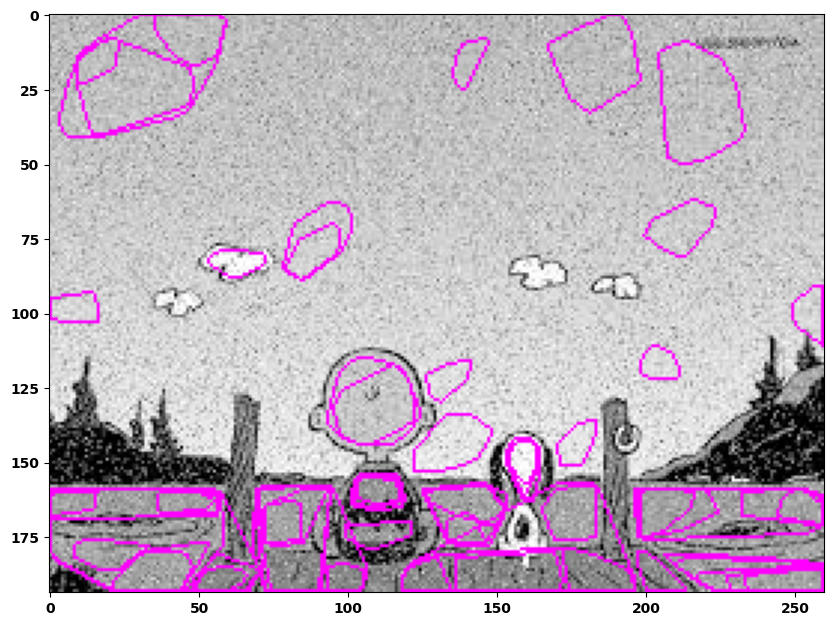

In [22]:
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(vis, hulls, 1, (255, 0, 255), 1)
plt.figure(figsize=(10,10))
plt.imshow(vis);

**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).